# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [3]:
pip install git+https://github.com/hollance/BlazeFace-PyTorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hollance/BlazeFace-PyTorch.git to /tmp/pip-req-build-_qoix8ng
  Running command git clone --filter=blob:none --quiet https://github.com/hollance/BlazeFace-PyTorch.git /tmp/pip-req-build-_qoix8ng
  Resolved https://github.com/hollance/BlazeFace-PyTorch.git to commit 852bfd8e3d44ed6775761105bdcead4ef389a538
ERROR: git+https://github.com/hollance/BlazeFace-PyTorch.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [4]:
import numpy as np
import torch
import cv2

In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.0.0+cu118
CUDA version: 11.8
cuDNN version: 8700


In [6]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cpu')

Helper code for making plots:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

In [8]:
import cv2
import numpy as np
from blazeface import BlazeFace


In [9]:
# Load the BlazeFace model
face_detector = BlazeFace()
face_detector.load_weights("blazeface.pth")
face_detector.load_anchors("anchors.npy")

# Set the video source
video_path = "path/to/your/video.mp4"
cap = cv2.VideoCapture(video_path)


In [10]:
while True:
    # Read the frame from the video
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the frame to RGB and resize
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (1280, 720))
    
    # Detect faces
    try:
        faces = face_detector.predict_on_image(frame)
    except BlazeFaceError:
        continue
    
    # Draw bounding boxes around the detected faces
    for face in faces:
        x, y, w, h = face.astype(int)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Show the frame
    cv2.imshow("Frame", frame)
    
    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) == ord("q"):
        break


In [11]:
while True:
    # Read the frame from the video
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the frame to RGB and resize
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (1280, 720))
    
    # Detect faces
    try:
        faces = face_detector.predict_on_image(frame)
    except BlazeFaceError:
        continue
    
    # Draw bounding boxes around the detected faces
    for face in faces:
        x, y, w, h = face.astype(int)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Show the frame
    cv2.imshow("Frame", frame)
    
    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) == ord("q"):
        break


## Load the front and back models

In [14]:
from blazeface import BlazeFace

front_net = BlazeFace().to(gpu)
front_net.load_weights("blazeface.pth")
front_net.load_anchors("anchors.npy")
back_net = BlazeFace(back_model=True).to(gpu)
back_net.load_weights("blazefaceback.pth")
back_net.load_anchors("anchorsback.npy")

# Optionally change the thresholds:
front_net.min_score_thresh = 0.75
front_net.min_suppression_threshold = 0.3

## Make a prediction

The input image should be 128x128 for the front model and 256x256 for the back model. BlazeFace will not automatically resize the image, you have to do this yourself!

In [16]:
img = cv2.imread("1face.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [17]:
front_detections = front_net.predict_on_image(img)
front_detections.shape

torch.Size([3, 17])

In [18]:
front_detections

tensor([[0.2322, 0.3842, 0.3959, 0.5479, 0.4299, 0.2870, 0.5000, 0.2731, 0.4704,
         0.3231, 0.4743, 0.3544, 0.3911, 0.3020, 0.5414, 0.2758, 0.9379],
        [0.2801, 0.6613, 0.4748, 0.8560, 0.7021, 0.3246, 0.7748, 0.3422, 0.7056,
         0.3777, 0.7050, 0.4184, 0.6897, 0.3320, 0.8492, 0.3726, 0.9417],
        [0.1635, 0.1818, 0.3191, 0.3374, 0.2332, 0.2095, 0.2946, 0.1936, 0.2775,
         0.2311, 0.2818, 0.2674, 0.1908, 0.2415, 0.3236, 0.2078, 0.8520]])

Found 3 faces


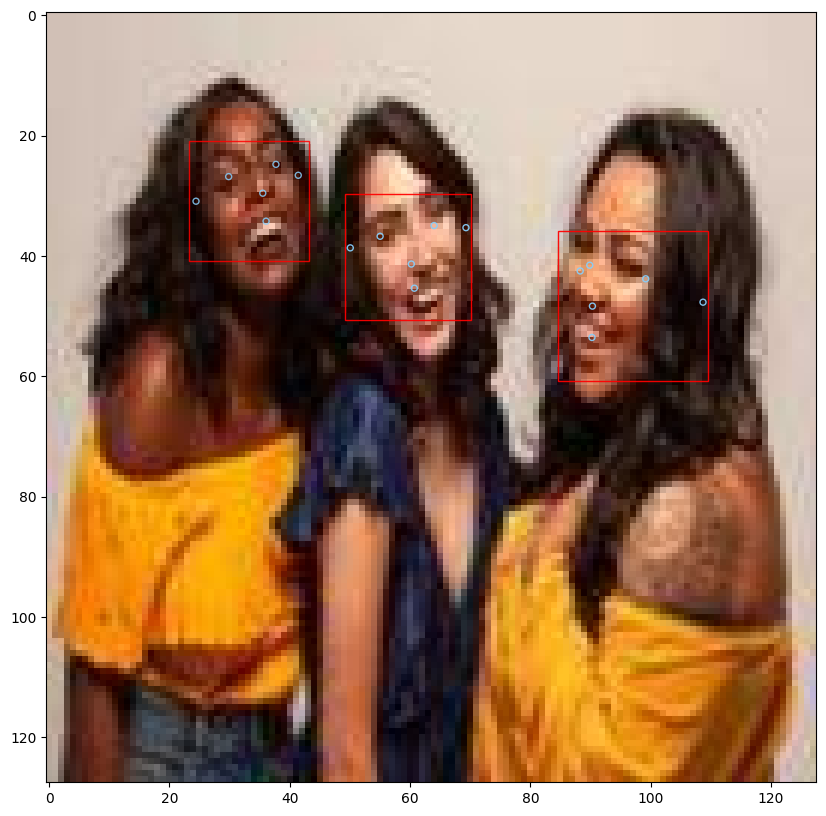

In [19]:
plot_detections(img, front_detections)

In [20]:
img2 = cv2.resize(img, (256, 256))
back_detections = back_net.predict_on_image(img2)
back_detections.shape

torch.Size([3, 17])

In [21]:
back_detections

tensor([[0.2349, 0.3786, 0.4118, 0.5555, 0.4414, 0.2901, 0.5110, 0.2709, 0.4986,
         0.3233, 0.5037, 0.3632, 0.3875, 0.3202, 0.5375, 0.2780, 0.7111],
        [0.1785, 0.1844, 0.3315, 0.3373, 0.2310, 0.2193, 0.2969, 0.2005, 0.2819,
         0.2324, 0.2891, 0.2745, 0.1867, 0.2638, 0.3278, 0.2215, 0.7147],
        [0.2742, 0.6726, 0.4410, 0.8394, 0.7003, 0.3154, 0.7589, 0.3384, 0.6951,
         0.3704, 0.6969, 0.4013, 0.7027, 0.3102, 0.8336, 0.3583, 0.6937]])

Found 3 faces


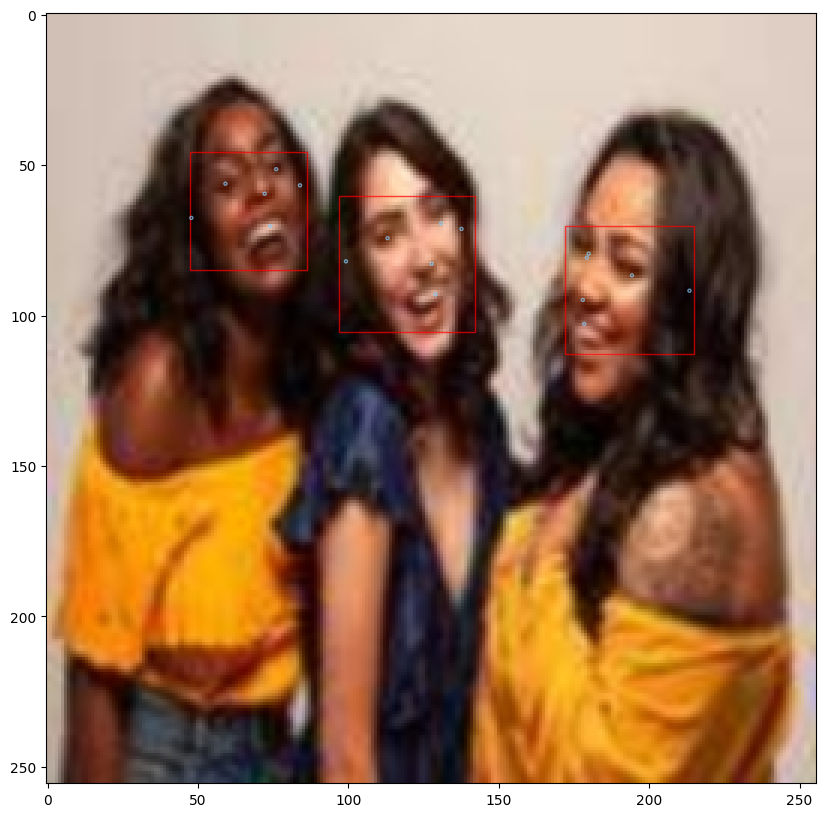

In [22]:
plot_detections(img2, back_detections)

## Make prediction on a batch of images

Load the images into a NumPy array of size `(batch, 128, 128, 3)` for front model or of size `(batch, 256, 256, 3)` for back model. Note: You could also use a PyTorch tensor here, in which case the shape must be `(batch, 3, 128, 128)` or `(batch, 3, 256, 256)`.

In [23]:
filenames = [ "1face.jpg", "3faces.png", "4faces.png" ]

xfront = np.zeros((len(filenames), 128, 128, 3), dtype=np.uint8)
xback = np.zeros((len(filenames), 256, 256, 3), dtype=np.uint8)

for i, filename in enumerate(filenames):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xfront[i] = img
    xback[i] = cv2.resize(img, (256, 256))

In [24]:
front_detections = front_net.predict_on_batch(xfront)
[d.shape for d in front_detections]

[torch.Size([3, 17]), torch.Size([3, 17]), torch.Size([0, 17])]

In [25]:
front_detections

[tensor([[0.2322, 0.3842, 0.3959, 0.5479, 0.4299, 0.2870, 0.5000, 0.2731, 0.4704,
          0.3231, 0.4743, 0.3544, 0.3911, 0.3020, 0.5414, 0.2758, 0.9379],
         [0.2801, 0.6613, 0.4748, 0.8560, 0.7021, 0.3246, 0.7748, 0.3422, 0.7056,
          0.3777, 0.7050, 0.4184, 0.6897, 0.3320, 0.8492, 0.3726, 0.9417],
         [0.1635, 0.1818, 0.3191, 0.3374, 0.2332, 0.2095, 0.2946, 0.1936, 0.2775,
          0.2311, 0.2818, 0.2674, 0.1908, 0.2415, 0.3236, 0.2078, 0.8520]]),
 tensor([[0.3443, 0.0852, 0.4834, 0.2244, 0.1335, 0.3838, 0.1981, 0.3769, 0.1788,
          0.4125, 0.1769, 0.4428, 0.0832, 0.4031, 0.2211, 0.3888, 0.9991],
         [0.3270, 0.7762, 0.4765, 0.9256, 0.8064, 0.3708, 0.8683, 0.3571, 0.8276,
          0.3952, 0.8355, 0.4299, 0.7934, 0.3984, 0.9291, 0.3740, 0.9968],
         [0.3454, 0.4172, 0.4805, 0.5523, 0.4581, 0.3886, 0.5141, 0.3864, 0.4884,
          0.4244, 0.4891, 0.4475, 0.4259, 0.3933, 0.5457, 0.3888, 0.9245]]),
 tensor([], size=(0, 17))]

Found 3 faces


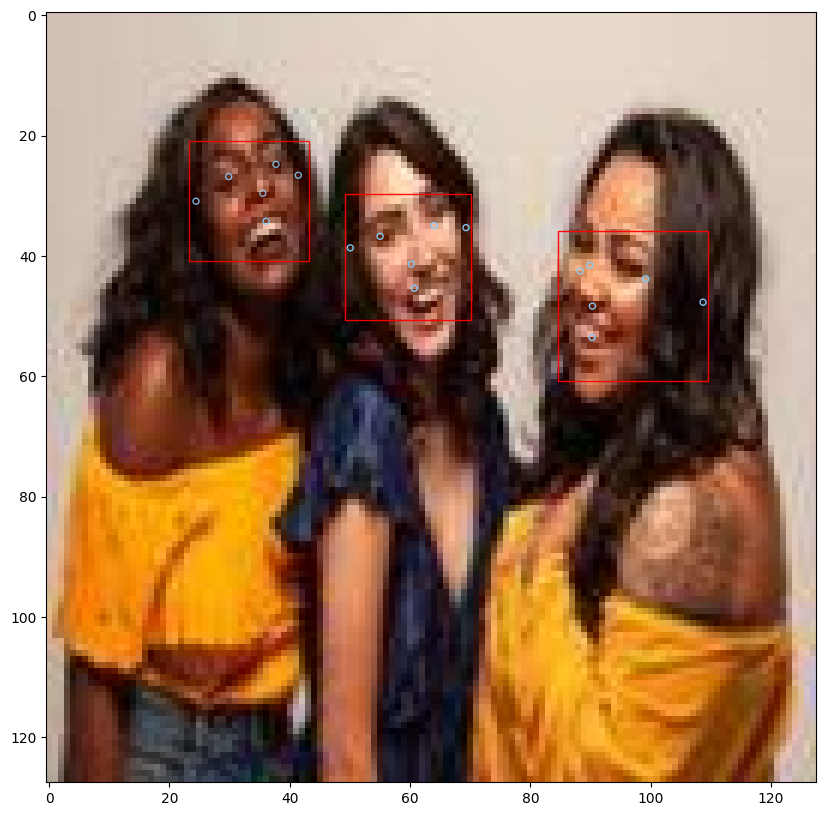

In [26]:
plot_detections(xfront[0], front_detections[0])

Found 3 faces


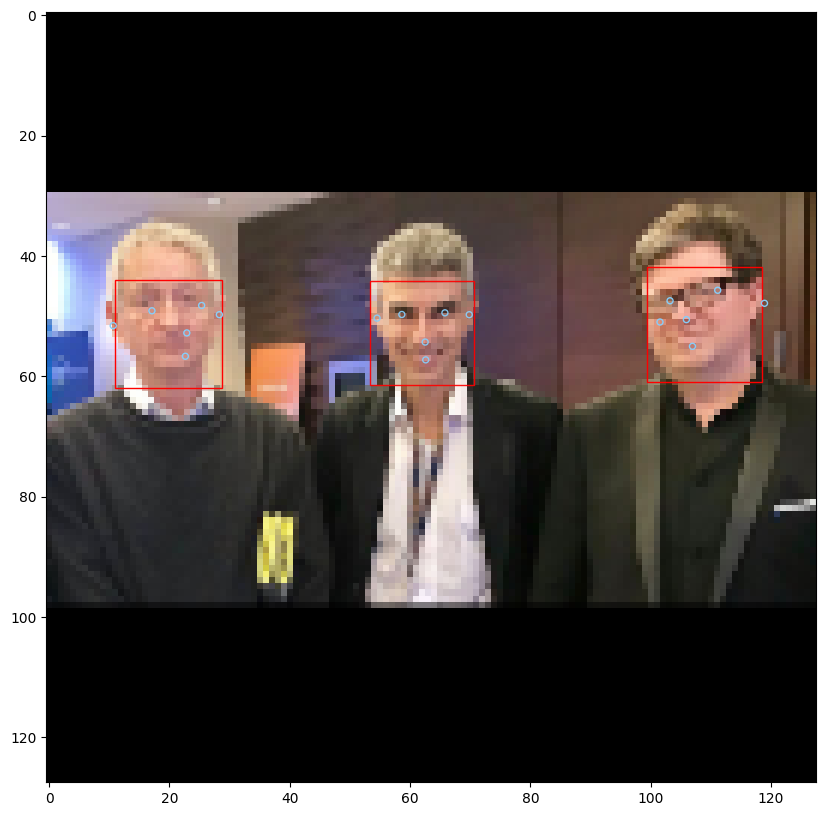

In [27]:
plot_detections(xfront[1], front_detections[1])

Found 0 faces


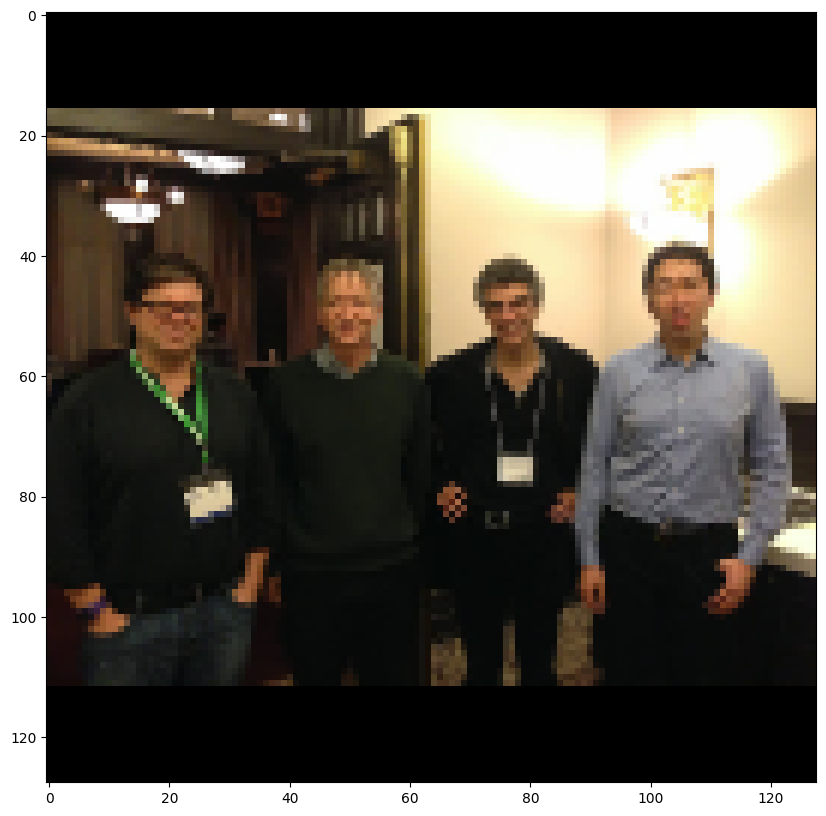

In [28]:
plot_detections(xfront[2], front_detections[2])

In [29]:
back_detections = back_net.predict_on_batch(xback)
[d.shape for d in back_detections]

[torch.Size([3, 17]), torch.Size([3, 17]), torch.Size([3, 17])]

In [30]:
back_detections

[tensor([[0.2349, 0.3786, 0.4118, 0.5555, 0.4414, 0.2901, 0.5110, 0.2709, 0.4986,
          0.3233, 0.5037, 0.3632, 0.3875, 0.3202, 0.5375, 0.2780, 0.7111],
         [0.1785, 0.1844, 0.3315, 0.3373, 0.2310, 0.2193, 0.2969, 0.2005, 0.2819,
          0.2324, 0.2891, 0.2745, 0.1867, 0.2638, 0.3278, 0.2215, 0.7147],
         [0.2742, 0.6726, 0.4410, 0.8394, 0.7003, 0.3154, 0.7589, 0.3384, 0.6951,
          0.3704, 0.6969, 0.4013, 0.7027, 0.3102, 0.8336, 0.3583, 0.6937]]),
 tensor([[0.3509, 0.4300, 0.4777, 0.5568, 0.4627, 0.3937, 0.5174, 0.3916, 0.4888,
          0.4293, 0.4912, 0.4488, 0.4368, 0.3943, 0.5521, 0.3893, 0.8168],
         [0.3336, 0.7804, 0.4642, 0.9109, 0.8029, 0.3691, 0.8574, 0.3636, 0.8212,
          0.3935, 0.8284, 0.4229, 0.7916, 0.3877, 0.9104, 0.3778, 0.8559],
         [0.3393, 0.0909, 0.4737, 0.2252, 0.1293, 0.3777, 0.1876, 0.3743, 0.1611,
          0.4077, 0.1627, 0.4354, 0.0957, 0.3924, 0.2201, 0.3842, 0.8399]]),
 tensor([[0.3421, 0.7887, 0.4160, 0.8626, 0.8104, 0.35

Found 3 faces


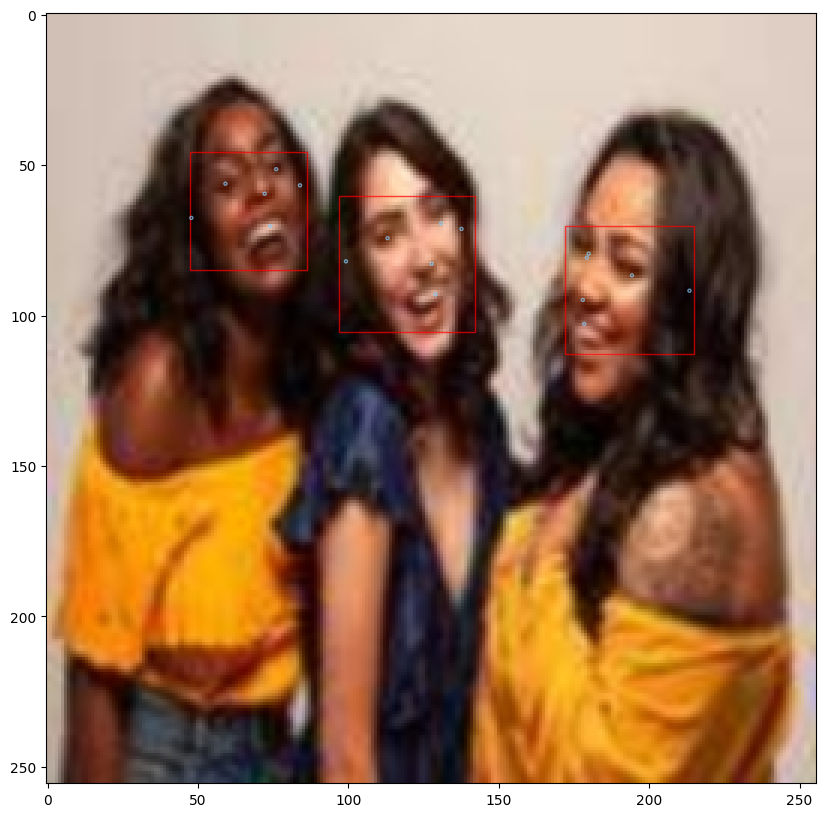

In [31]:
plot_detections(xback[0], back_detections[0])

Found 3 faces


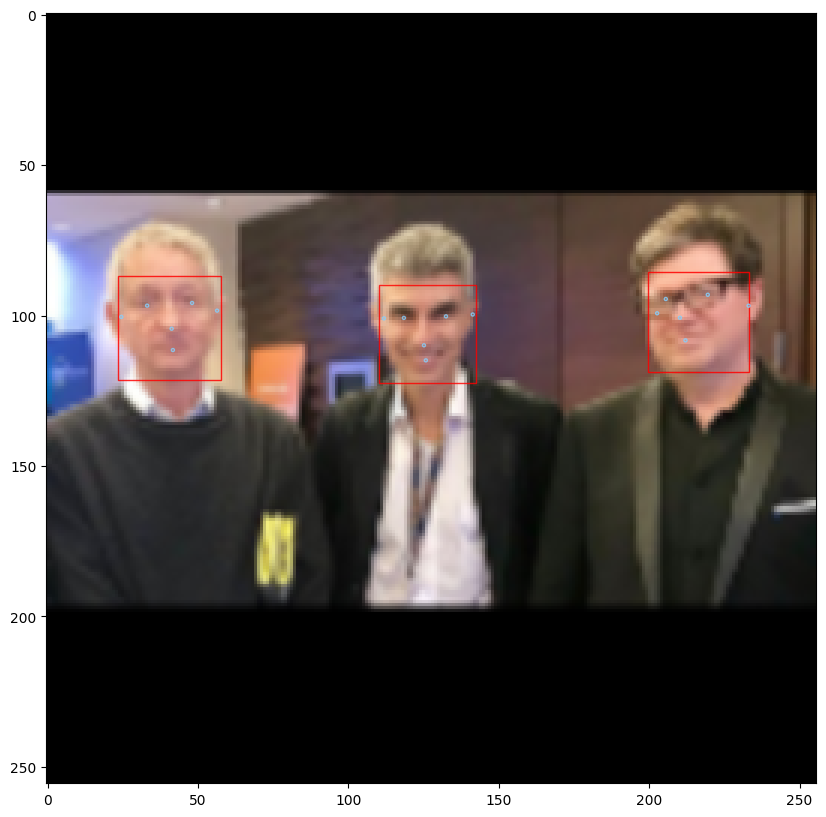

In [32]:
plot_detections(xback[1], back_detections[1])

Found 3 faces


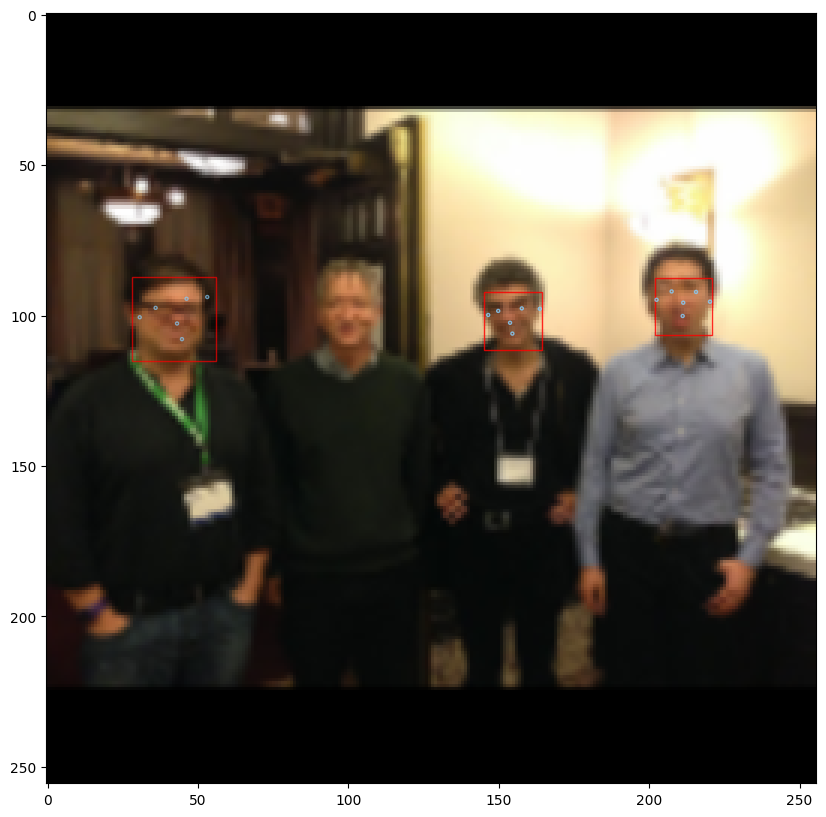

In [33]:
plot_detections(xback[2], back_detections[2])

## **Face Detection in Video**


In [ ]:
cap.release()
cv2.destroyAllWindows()


In [33]:
import cv2
from blazeface import BlazeFace

# Load the BlazeFace detector
detector = BlazeFace()

# Load the video stream
cap = cv2.VideoCapture(scr="video1.avi")

# Check if the video stream was opened successfully
if not cap.isOpened():
    print("Error opening video stream")
    exit()

# Loop over the frames from the video stream
while True:
    # Read the frame from the video stream
    ret, frame = cap.read()

    # If the frame was not read successfully, break from the loop
    if not ret:
        break

    # Convert the frame to RGB
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    try:
        # Detect faces in the frame using BlazeFace
        faces = detector.predict_on_image(rgb)

        # Draw a rectangle around each detected face
        for face in faces:
            x, y, w, h = face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    except BlazeFaceError:
        pass

    # Display the resulting frame
    cv2.imshow('Frame', frame)

    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and destroy all windows
cap.release()
cv2.destroyAllWindows()
